In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from IPython.display import Image
%matplotlib inline

import seaborn as sns

Рассмотрим нелинейную систему

 \begin{cases}
   sin(x+2)-y=1.5\\
   x+cos(y-2) = 0.5
 \end{cases}

In [2]:
'''Данное решение было получена с использованием WolframAlpha'''
x_true = [1.34634, -1.70332] # WolframAlpha computation

## МПИ

 Сведем систему к виду $u = f(u)$:

 \begin{cases}
   x = 0.5 - cos(y-2)\\
   y = sin(x+2)- 1.5\\
 \end{cases}
 
 $u^n+1 = f(u^n)$ - МПИ, где $f(x, y) = \begin{pmatrix}
 0.5 - cos(y-2) \\
 sin(x+2) - 1.5
 \end{pmatrix}$

$\|f(u_1) - f(u_2)\|_3 = \sqrt{(cos(y_1-2)-cos(y_2-2))^2+(sin(x_1+2)-sin(x_2+2))^2} \le 4 \sqrt{2} \le q \cdot \sqrt{(y_1-y_2)^2+(x_1-x_2)^2} = q \, \|u_1 - u_2\|_3$

Пусть $q=\frac{1}{\sqrt{2}}$, тогда положим $\Omega = [-1,1] \times [-1,1]$ - область сходимости (ее подмножество).

На этой области $\|u^n - u^* \|_3 \le \frac{q^n \|x_1-x_0\|_3}{1-q}$

_Замечание:_ Данная оценка грубая и не претендует на точность. Далее будет исследована сходимость вне указанной области. 

In [3]:
# ф-ция f
def f(u):
    x, y = u
    return [0.5-np.cos(y-2), np.sin(x+2)-1.5]

In [4]:
# евклидова норма в R^2
def p(u1, u2):
    return ((u1[0]-u2[0])**2 + (u1[1]-u2[1])**2)**0.5

In [5]:
# метод простой итерации
def msi(u0, eps, verbose=False, extend=False):
    x, y = u0
    fst_step = p(f([x,y]), [x,y])
    n = 0
    q = 0.5**0.5
    extend_xs, extend_ys = [x], [y]
    while not q**n*fst_step/(1-q) < eps:
        x, y = f([x, y])
        extend_xs.append(x)
        extend_ys.append(y)
        n += 1
    if verbose:
        print(f'Метод сошелся за {n} итераций')
    if extend:
        return extend_xs, extend_ys
    return [x, y]

In [6]:
u0 = [0,0]
eps = 1e-5
res = msi(u0, eps, verbose=True)
print(f"Результат: {res}, ошибка в евк. норме: {p(res, x_true)}")

Метод сошелся за 38 итераций
Результат: [1.3463376916362608, -1.7033151859394335], ошибка в евк. норме: 5.338887739012573e-06


Рассмотрим сходимость метода вне указнной области. 

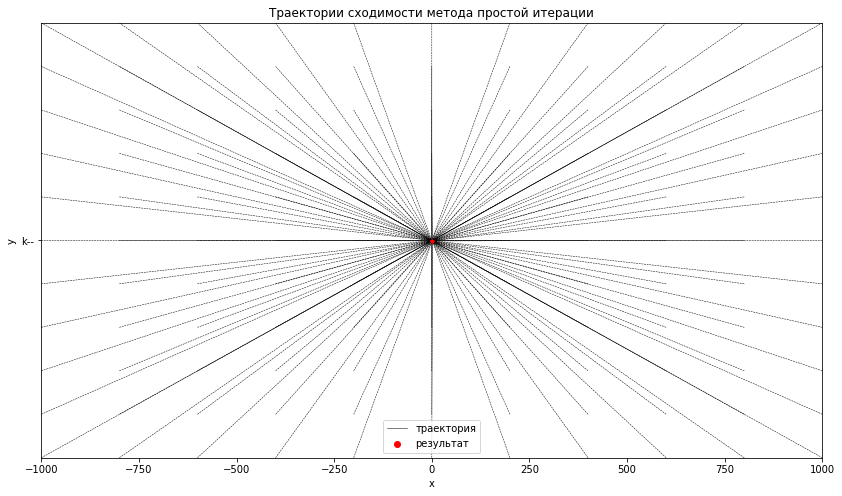

In [7]:
N = 1000
X = np.linspace(-N, N, 11)
Y = np.linspace(-N, N, 11)

plt.figure(figsize=(14,8))
plt.xlim((-N, N))
plt.ylim((-N, N))
plt.plot('k--', lw=0.5, c='black', label='траектория');
plt.scatter([], [], c='r', label='результат')
plt.title('Траектории сходимости метода простой итерации');
plt.xlabel('x');
plt.ylabel('y');

for x in X:
    for y in Y:
        xs, ys = msi([x, y], 1e-5, extend=True)
        plt.plot(xs, ys, 'k--', lw=0.5, zorder=0)
        plt.scatter(xs[-1:], ys[-1:], c='r', s=5, zorder=10);
        
plt.legend();

Истинная область сходимости метода: $\Omega = \textbf{R}^2$

## Метод Ньютона

 \begin{cases}
   x - 0.5 + cos(y-2) = 0\\
   y - sin(x+2) + 1.5 = 0\\
 \end{cases}
 
 $u^{n+1} = u^n - J^{-1} F(u^n)$ - МПИ, где $F(x, y) = \begin{pmatrix}
 x - 0.5 + cos(y-2) \\
 y - sin(x+2) + 1.5
 \end{pmatrix}$ и 
 $J = \begin{pmatrix}
 1 & -sin(y-2) \\
 -cos(x+2) & 1
 \end{pmatrix}$
 
 Отметим, что 
 $J^{-1} = \frac{1}{1-sin(y-2)cos(x+2)} \begin{pmatrix}
 1 & sin(y-2) \\
 cos(x+2) & 1
 \end{pmatrix}$

В связи с трудностью теоретической проверки достаточного условия сходимости исследуем сходимость метода для всего пространства. 

In [8]:
# вычисление обратной матрицы
def inv_J(u):
    x, y = u
    return np.dot([[1, np.sin(y-2)], [np.cos(x+2), 1]], 1/(1-np.sin(y-2)*np.cos(x+2)))

In [9]:
# ф-ция F
def F(u):
    x, y = u
    return [x-0.5+np.cos(y-2), y-np.sin(x+2)+1.5]

In [10]:
# метод Ньютона
def Newton_method(u0, iter_num):
    x, y = u0
    for _ in range(iter_num):
        x, y = x - np.dot(inv_J([x,y]), F([x,y]))[0], y - np.dot(inv_J([x,y]), F([x,y]))[1]
    return [x, y]

In [11]:
res = Newton_method([0, 0], 100)
print(f"Результат: {res}, ошибка в евк. норме: {p(res, x_true)}")

Результат: [1.3463376449191482, -1.703317484248414], ошибка в евк. норме: 3.4460719465942284e-06


In [12]:
N = 100
dim = 201
X = np.linspace(-N, N, dim)
Y = np.linspace(-N, N, dim)

converge_matrix = np.zeros((dim, dim))

for i, x in enumerate(X):
    for j, y in enumerate(Y):
        x, y = Newton_method([x, y], 100)
        if p([x, y], x_true) < 0.001:
            converge_matrix[i][j] = 1
        else:
            converge_matrix[i][j] = -1

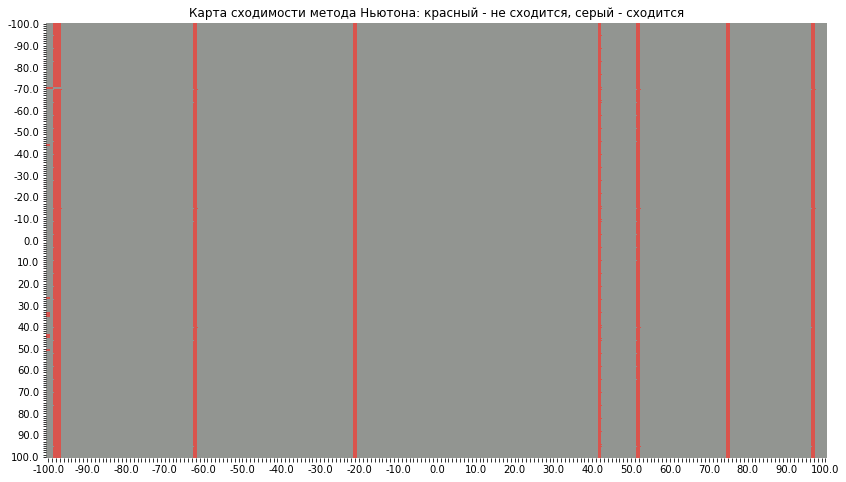

In [13]:
plt.figure(figsize=(14,8))
colors = ["pale red", "grey"]
xlabs = list(map(lambda x: x if list(X).index(x)%10==0 else '', X))
ylabs = list(map(lambda y: y if list(Y).index(y)%10==0 else '', Y))
plt.title('Карта сходимости метода Ньютона: красный - не сходится, серый - сходится')
sns.heatmap(converge_matrix, xticklabels=xlabs, yticklabels=ylabs, cmap=sns.xkcd_palette(colors), cbar=False);

Область сходимости трудно проинтерпретировать.

## Оптимизационный метод

Рассмотрим функционал: $F(x,y) = (sin(x+2)-y-1.5)^2+(x+cos(y-2)-0.5)^2$

Рассмотрим задачу оптимизации: $F(x,y) \rightarrow min$

In [14]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [15]:
x = np.linspace(-15, 14, 100)
y = np.linspace(-15, 14, 100)
Y, X = np.meshgrid(x, y)

Z = (np.sin(X+2) - Y - 1.5)**2 + (X+np.cos(Y-2)-0.5)**2

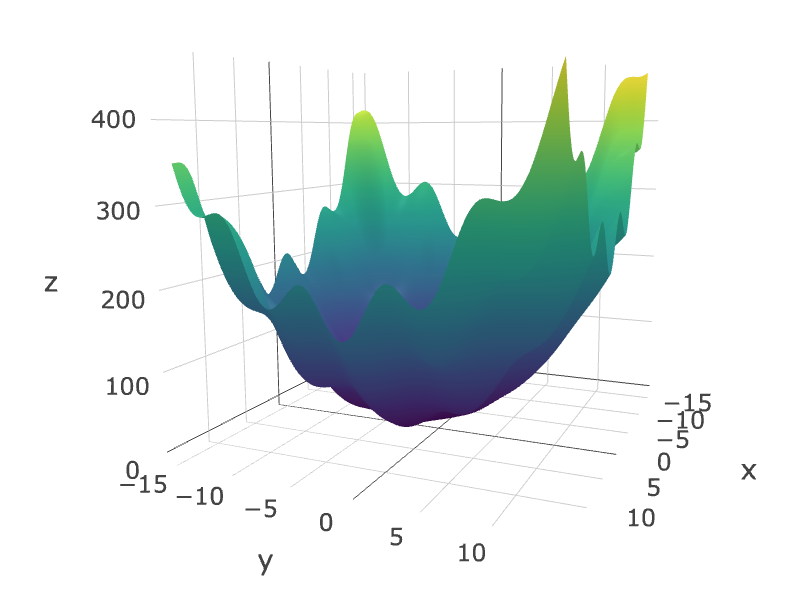

In [16]:
#init_notebook_mode(connected=True)
#trace = go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')
#iplot([trace])
Image("fig.png")
'''График функционала F(x,y)'''

Общее утверждение: $F(x,y)$ - выпуклая или в худшем случае **квазивыпуклая**. 

$\bigtriangledown F(x,y) = 
\begin{bmatrix} 
    2(sin(x+2)-y-1.5)\, cos(x+2)+(x+cos(y-2)-0.5) & -(sin(x+2)-y-1.5)-(x+cos(y-2)-0.5) \, sin(y-2)
\end{bmatrix} $

## Gradient Descent

In [17]:
# функция расчета градиента исследуемой функции в точке x
def grad(xy):
    x, y = xy
    g1 = 2*(np.sin(x+2)-y-1.5)*np.cos(x+2) + (x+np.cos(y-2)-0.5)
    g2 = -(np.sin(x+2)-y-1.5) - (x+np.cos(y-2)-0.5)*np.sin(y-2)
    return [g1, g2]

In [18]:
# функция реализации градиентного спуска
def gradient_descent(step, x0=[0, 0], iterations=100):
    x = x0
    for _ in range(iterations):
        x -= np.dot(step, grad(x))
    return x

In [19]:
res = gradient_descent(step=0.1, x0=[1,-1], iterations=100)

print(f"Результат: {res}, ошибка в евк. норме: {p(res, x_true)}")

Результат: [ 1.34623497 -1.70317641], ошибка в евк. норме: 0.00017790583206036222


Рассмотрим изменение функционала ошибки _loss_ от номера итерации

$loss := \sqrt{(x_k-x^*)^2+(y_k-y^*)^2}$

In [20]:
def loss(x, x_true):
    return ((x[0]-x_true[0])**2 + (x[1]-x_true[1])**2)**0.5

In [21]:
iterations=100
x = [1,-1]
step = 0.3
iters, losses = range(iterations+1), [loss(x, x_true)]
for i in range(iterations):
    x -= np.dot(step, grad(x))
    losses += [loss(x, x_true)]

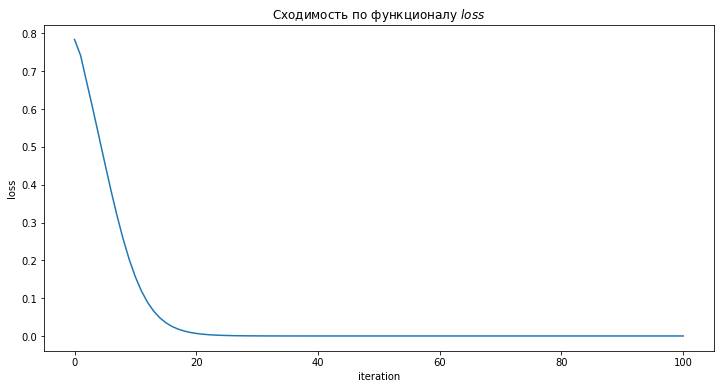

In [22]:
plt.figure(figsize=(12,6))
plt.title("Сходимость по функционалу $loss$")
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(iters, losses);

### Графика сходимости метода

In [23]:
def convergence(step, x0, Nmax):
    xs, ys = [], []
    for N in range(Nmax):
        gd = gradient_descent(step=step, x0=x0, iterations=N)
        xs.append(gd[0])
        ys.append(gd[1])
    return xs, ys

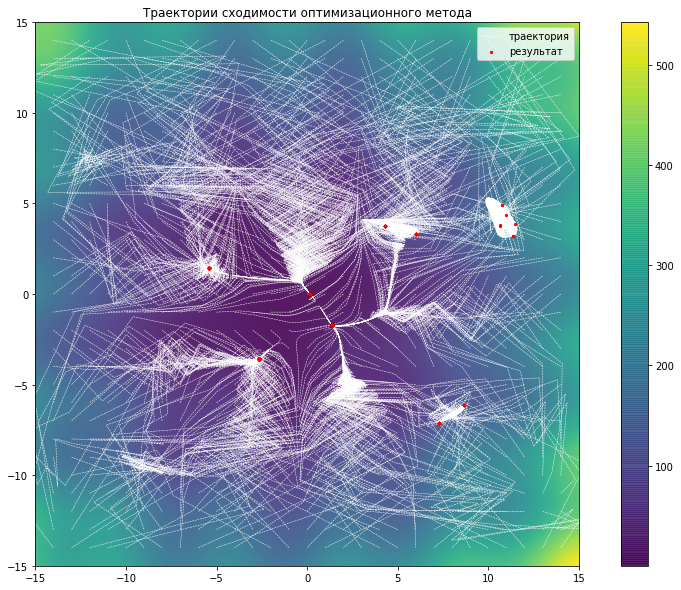

In [24]:
x = np.linspace(-15, 15, 1000)
y = np.linspace(-15, 15, 1000)
Y, X = np.meshgrid(x, y)
Z = (np.sin(X+2) - Y - 1.5)**2 + (X+np.cos(Y-2)-0.5)**2

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig, ax = plt.subplots(figsize=(15, 10))
depth = ax.imshow(Z, cmap='viridis', interpolation='none', extent=extent, alpha=.9);
fig.colorbar(depth, ax=ax);
plt.xlim((-15,15))
plt.ylim(-15,15)

final_xs, final_ys = list(), list()

Nmax = 100
step = 0.25
for i in range(-14, 15):
    for j in range(-14, 15):
        x0 = [i, j]
        xs, ys = convergence(step, x0, Nmax)
        ax.plot(xs, ys, 'k--', c='white', lw=.5)
        final_xs += [xs[-1]]
        final_ys += [ys[-1]]
        
plt.scatter(final_xs, final_ys, c='r', s=5, zorder=10, label='результат');
plt.plot([], [], 'k--', c='white', lw=.5, label='траектория')
plt.legend();
plt.title('Траектории сходимости оптимизационного метода');

Метод не оптимален в силу того, что функция не является выпуклой и невыпуклый анализ приводит к нахождению не только глобального минимума, то есть решения исходной системы, но и локальных минимумов, в которых мы не заинтересованы.